In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import cv2
import math
import numpy as np
import glob
from collections import deque

In [2]:
training_data = np.load('data/training.npy', allow_pickle=True) # shape: (frame, calibration)
test_data = np.load('data/test.npy', allow_pickle=True) # shape: (frame,)

In [5]:
# TODO:
# Debug / improve image -> hough lines processing
# Calculate the vanishing point from the hough lines
# Make sure to handle NaN values

im = Image.fromarray(test_data[5000])
im2 = Image.fromarray(training_data[5000][0])
im.show()
im2.show()

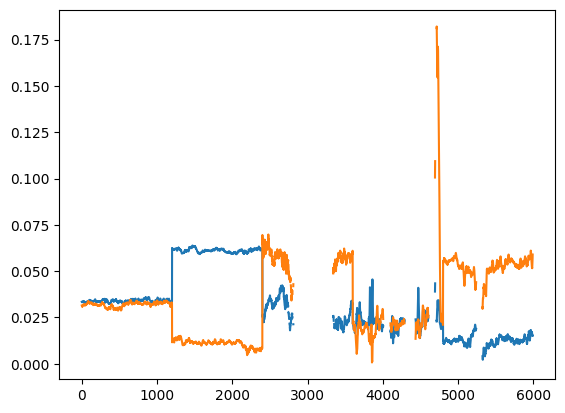

In [5]:
radians = training_data[:,1]
r1 = [r1 for r1, _ in radians]
r2 = [r2 for _, r2 in radians]
x = [i for i in range(len(radians))]

plt.plot(x, r1, label='r1')
plt.plot(x, r2, label='r2')

In [19]:
# Playing around with the data
frame1 = test_data[0]
frame1[0,0]
# test = frame1[:, :, 2].squeeze()
# df = pd.DataFrame(test[0:100,0:100])
# df.style.set_properties(**{'font-size':'6pt'}).background_gradient()

array([143,  91,  49], dtype=uint8)

In [48]:
# CODE IN THIS BLOCK IS FROM https://github.com/commaai/openpilot/tree/master/common/transformations

# TESTING
focal_length = 910.0
frame_size = (1164, 874)

# aka 'K' aka camera_frame_from_view_frame
calib_challenge_intrinsics = np.array([
  [focal_length,  0.0,  float(frame_size[0])/2],
  [0.0,  focal_length,  float(frame_size[1])/2],
  [0.0,  0.0,                              1.0]])


def normalize(img_pts, intrinsics=calib_challenge_intrinsics):
  # normalizes image coordinates
  # accepts single pt or array of pts
  intrinsics_inv = np.linalg.inv(intrinsics)
  img_pts = np.array(img_pts)
  input_shape = img_pts.shape
  img_pts = np.atleast_2d(img_pts)
  img_pts = np.hstack((img_pts, np.ones((img_pts.shape[0], 1))))
  img_pts_normalized = img_pts.dot(intrinsics_inv.T)
  img_pts_normalized[(img_pts < 0).any(axis=1)] = np.nan
  return img_pts_normalized[:, :2].reshape(input_shape)


def get_calib_from_vp(vp):
  vp_norm = normalize(vp)
  yaw_calib = np.arctan(vp_norm[0])
  pitch_calib = -np.arctan(vp_norm[1]*np.cos(yaw_calib))
  roll_calib = 0
  return roll_calib, pitch_calib, yaw_calib

# Test to add for going from vp -> _roll, pitch, yaw: make the vp the center of the camera and see if 
# all angles are 0

# inserting a single point
test_vp = np.array([frame_size[0]/2, frame_size[1]/2])
roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(test_vp)
assert(roll_calib == 0.0 and pitch_calib == 0.0 and yaw_calib == 0.0), "Error with vp -> calibration step"

# inserting a list of points
# test_vp = np.array([frame_size[0]/2, frame_size[1]/2])
# test_vps = [test_vp, test_vp, test_vp, test_vp]
# roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(test_vps)
# print(len(pitch_calib))
# assert(roll_calib == 0.0 and pitch_calib == 0.0 and yaw_calib == 0.0), "Error with vp -> calibration step"


TypeError: object of type 'numpy.float64' has no len()

In [36]:
# # Tested assumption that when vp = center of img, the pitch = yaw = 0.0 would yield 100% MSE according to eval.py (it does)

# # vid[0] is the name of the file, vid[1] is the video data
# vid_5 = ('unlabeled/5.txt', test_data[:1200])
# vid_6= ('unlabeled/6.txt', test_data[1200:2400])
# vid_7 = ('unlabeled/7.txt', test_data[2400:3600])
# vid_8 = ('unlabeled/8.txt', test_data[3600:4800])
# vid_9 = ('unlabeled/9.txt', test_data[4800:5996])
# test_videos = [vid_5, vid_6, vid_7, vid_8, vid_9]

# def generate_and_write_test_labels(vid):
#   with open(vid[0], 'w') as f:
#       for frame in vid[1]:
#           vp = test_vp # TODO: replace with function to determine the vp from the frame!
#           _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
#           f.write(f'{pitch_calib} {yaw_calib}\n')
#       f.close()
    
# for test_video in test_videos:
#     generate_and_write_test_labels(test_video)

# # rot means rotation matrix
# # print(len(vid_1))

# # # 0-3 are 1200 frames, 4 is 1196
# # def get_video_label_from_frame_idx(idx):
# #     if idx < 1200: video = 5
# #     elif idx < 2400: video = 6
# #     elif idx < 3600: video = 7
# #     elif idx < 4800: video = 8
# #     else: video = 9
# #     return f'{video}.txt'

# # def calc_test_calib_labels():
# #     for idx, frame in enumerate(test_data):
# #         video_label = get_video_label_from_frame_idx(idx)
        
# #     # _roll, pitch, yaw = get_calib_from_vp(test_vp)
    

# # print(get_video_label_from_frame_idx(0))
# # print(get_video_label_from_frame_idx(1201))
# # print(get_video_label_from_frame_idx(2401))
# # print(get_video_label_from_frame_idx(3601))
# # print(get_video_label_from_frame_idx(4801))
# # # calc_test_calib_labels()


In [38]:
def get_line_length(line):
    for x1, y1, x2, y2 in line:
        return np.sqrt((y2-y1)**2 + (x2-x1)**2)

def get_line_slope_intercept(line):
    for x1, y1, x2, y2 in line:
        if x2-x1 == 0:
            return math.inf, 0
    slope = (y2-y1)/(x2-x1)
    intercept = y1 - slope * x1
    return slope, intercept
        
def get_lines_slope_intecept(lines):
    left_lines = []
    right_lines = []
    left_lengths = []
    right_lengths = []
    for line in lines:
        slope, intercept = get_line_slope_intercept(line)
        if slope == math.inf:
            continue
        line_len = get_line_length(line)
        if slope < 0:
            left_lines.append((slope, intercept))
            left_lengths.append(line_len)
        else :
            right_lines.append((slope, intercept))
            right_lengths.append(line_len)
            
    # average
    left_avg = np.dot(left_lengths, left_lines)/np.sum(left_lengths) if len(left_lengths) > 0 else None
    right_avg = np.dot(right_lengths, right_lines)/np.sum(right_lengths) if len(right_lengths) > 0 else None
    
    return left_avg, right_avg

def convert_slope_intercept_to_line(y1, y2 , line):
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1- intercept)/slope)
    y1 = int(y1)
    x2 = int((y2- intercept)/slope)
    y2 = int(y2)
    return((x1, y1),(x2, y2))

def get_lane_lines(blank_img, lines):
    left_avg, right_avg = get_lines_slope_intecept(lines)
    
    y1 = blank_img.shape[0]
    y2 = blank_img.shape[0] * 0.6
    
    left_lane = convert_slope_intercept_to_line(y1, y2, left_avg)
    right_lane = convert_slope_intercept_to_line(y1, y2, right_avg)
    return left_lane, right_lane

def draw_weighted_lines(img, lines, color=[255, 0, 0], thickness=2, alpha = 1.0, beta = 0.95, gamma= 0):
    mask_img = np.zeros_like(img)
    for line in lines:
        if line is not None:
            cv2.line(mask_img, *line, color, thickness)            
    return weighted_img(mask_img, img, alpha, beta, gamma)

In [50]:
def get_bgr_to_gray_img(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_guassian_blur_img(img, skip_extra_blur, kernel_size=3):
    if skip_extra_blur: return img
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def get_canny_edge_detected_img(img, low_threshold=25, high_threshold=100):
    return cv2.Canny(img, low_threshold, high_threshold)

# def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
#     for line in lines:
#         print(line)
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def get_roi_from_img(img):
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    y, x = img.shape
    y_offset = -10
    x_offset = 100
    roi_vertices = np.array([[(150, y - 150),
                              (x / 2 - x_offset, y / 2 + y_offset),
                              (x / 2 + x_offset, y / 2 + y_offset),
                              (x - 150, y - 140)]],
                              dtype=np.int32)
    cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(img, img, mask=mask)
    return masked_edges
    
def get_hough_lines(img, rho=1, theta=np.pi/180, threshold=10, min_line_len=20, max_line_gap=200):
    rho = 1
    theta = 31 * np.pi/180
    threshold = 10
    min_line_length = 5
    max_line_gap = 20
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    return lines
    # lines_img = np.copy(img) * 0
    # for line in lines:
    #     for x0, y0, x1, y1 in line:
    #         cv2.line(lines_img, (x0, y0), (x1, y1), (255, 0, 0), 4)
    # return lines_img, lines

# def process_img(img, skip_extra_blur=True):
#     gray = get_bgr_to_gray_img(img)
#     # blur = get_guassian_blur_img(gray, skip_extra_blur)
#     canny = get_canny_edge_detected_img(blur)
#     masked_edges = get_roi_from_img(canny)
#     lines = get_hough_lines(masked_edges)
#     left_lane, right_lane = get_lane_lines(np.copy(img) * 0, lines)
#     return

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def show(imgs, cmap=None):
    rows = (len(imgs)+1)//2
    plt.figure(figsize=(10, 11))
    for i, img in enumerate(imgs):
        plt.subplot(rows, 2, i+1)
        cmap = 'gray' if len(img.shape)==2 else cmap
        plt.imshow(img, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=8)
    plt.show()




In [59]:
class LaneMemory:
    def __init__(self, max_entries=50):
        self.max_entries = max_entries
        self.left_lanes = deque(maxlen=self.max_entries)
        self.right_lanes = deque(maxlen=self.max_entries)
        
    def process(self, img):
        result, left_lane, right_lane = process_image(img, calc_mean=True, left_mem=self.left_lanes, right_mem=self.right_lanes)
        self.left_lanes.append(left_lane)
        self.right_lanes.append(right_lane)
        print(left_lane, right_lane)
        return result


def process_image(image, calc_mean=False, **kwargs):
    if calc_mean:
        assert('left_mem' in kwargs.keys())
        assert('right_mem' in kwargs.keys())
    
    copy_original_img = np.copy(image)
    
    # convert to grayscale
    gray_img = get_bgr_to_gray_img(copy_original_img)
    
    # Color Selection
    # white_mask = isolate_color_mask(to_hls(image), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
    # yellow_mask = isolate_color_mask(to_hls(image), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
    # mask = cv2.bitwise_or(white_mask, yellow_mask)
    # colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
    
    # Apply Gaussian Blur
    # blurred_img = gaussian_blur(colored_img, kernel_size=7)
    
    # Apply Canny edge filter
    # canny_img = canny(blurred_img, low_threshold=70, high_threshold=140)
    canny = get_canny_edge_detected_img(gray_img)
    
    # Get Area of Interest
    # aoi_img = get_aoi(canny_img)
    masked_edges = get_roi_from_img(canny)
    
    # Apply Hough lines
    # hough_lines = get_hough_lines(aoi_img)
    # hough_img = draw_lines(original_img, hough_lines)
    lines = get_hough_lines(masked_edges)
    
    
    # Extrapolation and averaging
    # left_lane, right_lane = get_lane_lines(original_img, hough_lines)
    left_lane, right_lane = get_lane_lines(copy_original_img, lines)
    
    if calc_mean:
        if left_lane is not None and right_lane is not None:
            kwargs['left_mem'].append(left_lane)
            kwargs['right_mem'].append(right_lane)
        left_mean = np.mean(kwargs['left_mem'], axis=0, dtype=np.int32)
        right_mean = np.mean(kwargs['right_mem'], axis=0, dtype=np.int32)
        left_lane_avg = tuple(map(tuple, left_mean))
        right_lane_avg = tuple(map(tuple, right_mean))
        result = draw_weighted_lines(copy_original_img, [left_lane_avg, right_lane_avg], thickness= 10)
        return result, left_lane, right_lane
    
    result = draw_weighted_lines(copy_original_img, [left_lane, right_lane], thickness= 10)
       
    return result, left_lane, right_lane


((-140, 874), (394, 524)) ((1991, 874), (111, 524))


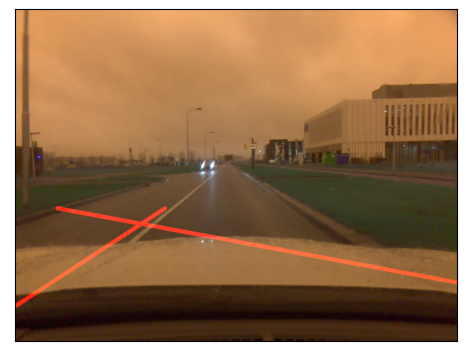

((-63, 874), (417, 524)) ((1882, 874), (246, 524))


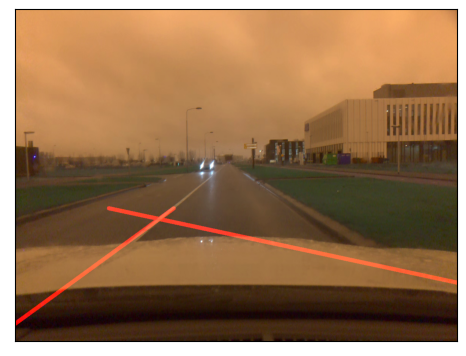

((-97, 874), (411, 524)) ((1813, 874), (258, 524))


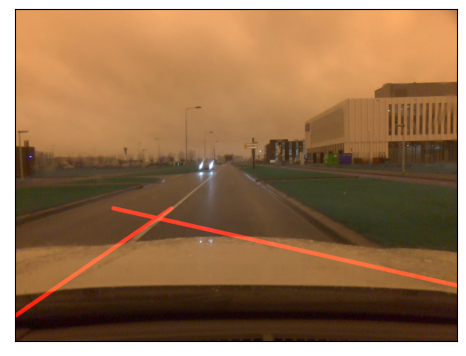

((-115, 874), (409, 524)) ((1755, 874), (327, 524))


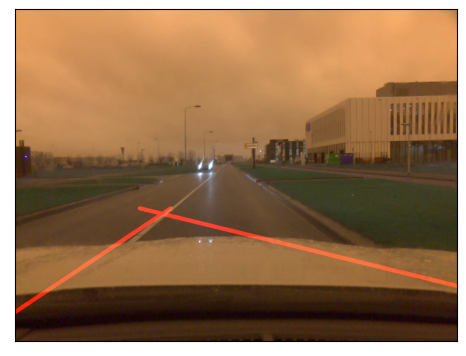

((65, 874), (430, 524)) ((1804, 874), (285, 524))


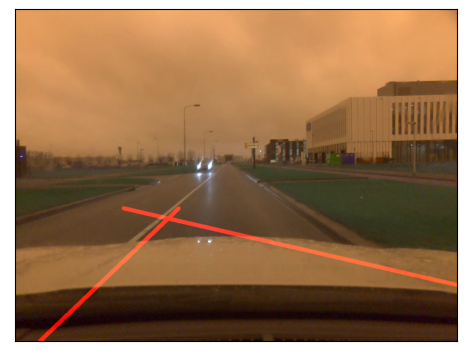

((8, 874), (412, 524)) ((1913, 874), (256, 524))


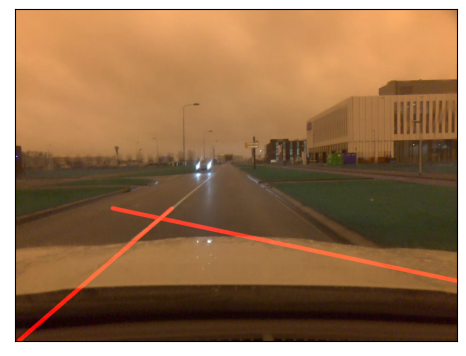

((-52, 874), (418, 524)) ((1538, 874), (371, 524))


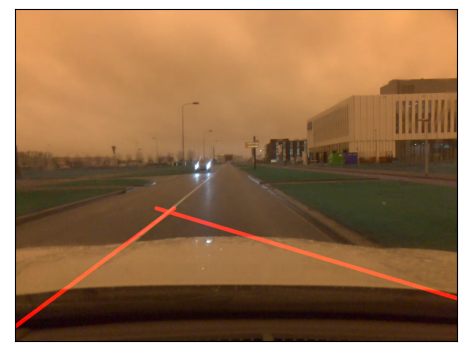

((38, 874), (420, 524)) ((1755, 874), (384, 524))


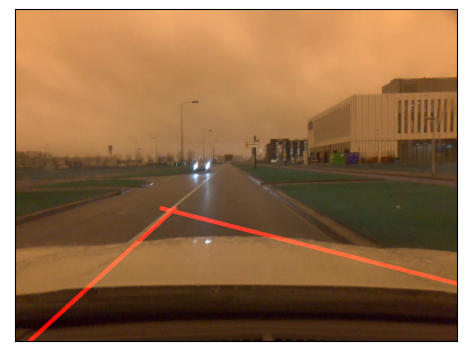

((100, 874), (432, 524)) ((1895, 874), (273, 524))


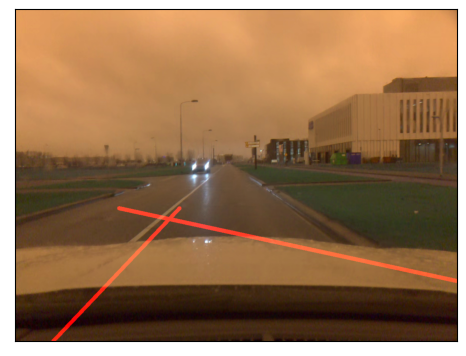

((160, 874), (433, 524)) ((1719, 874), (290, 524))


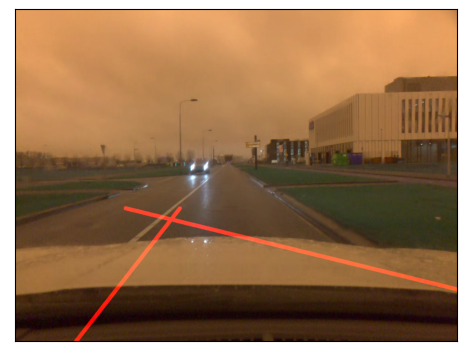

((121, 874), (423, 524)) ((1569, 874), (409, 524))


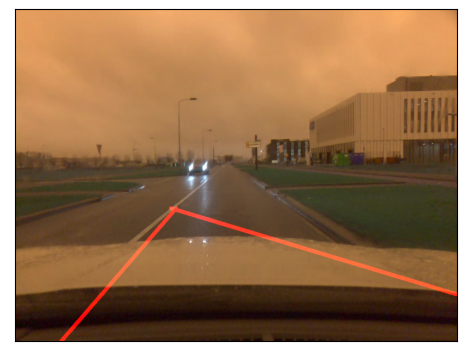

((124, 874), (424, 524)) ((1599, 874), (446, 524))


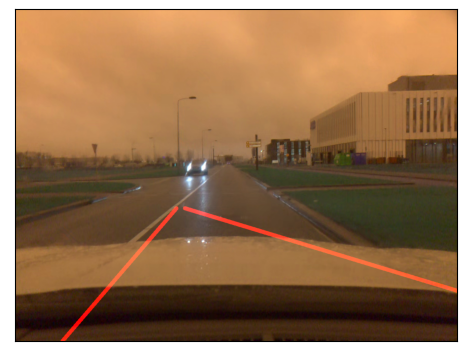

((124, 874), (435, 524)) ((1495, 874), (403, 524))


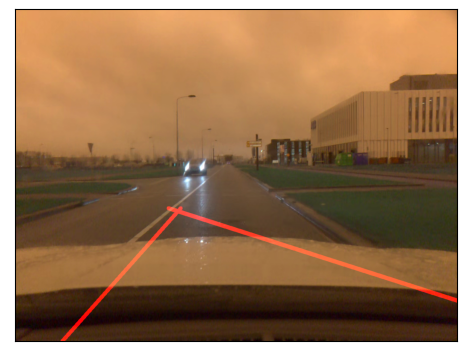

((103, 874), (416, 524)) ((1887, 874), (188, 524))


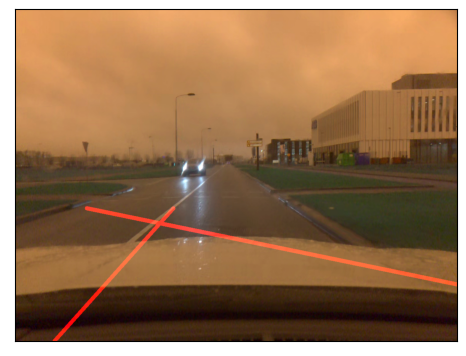

((68, 874), (427, 524)) ((1854, 874), (159, 524))


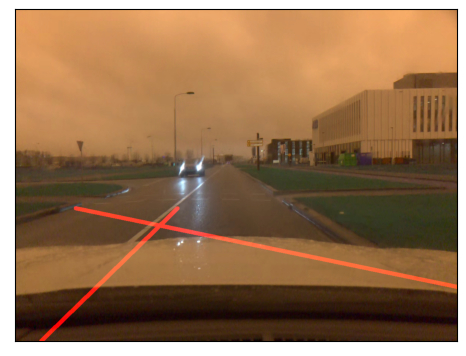

((76, 874), (431, 524)) ((1773, 874), (370, 524))


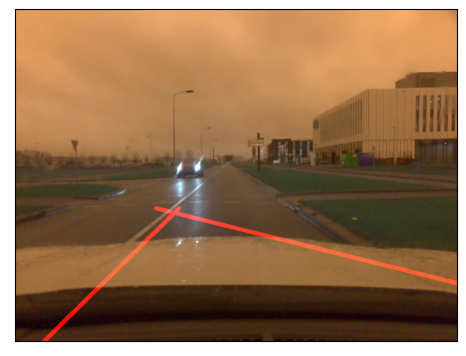

((98, 874), (406, 524)) ((2048, 874), (81, 524))


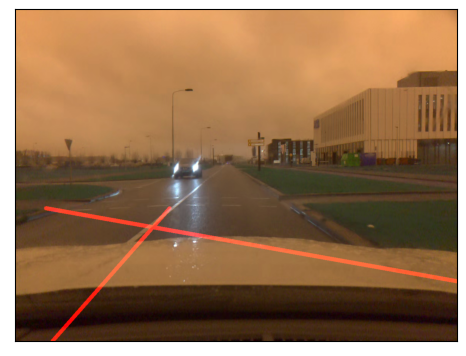

((132, 874), (414, 524)) ((1061, 874), (348, 524))


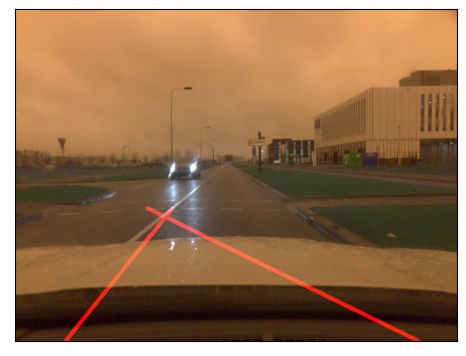

((93, 874), (412, 524)) ((1634, 874), (178, 524))


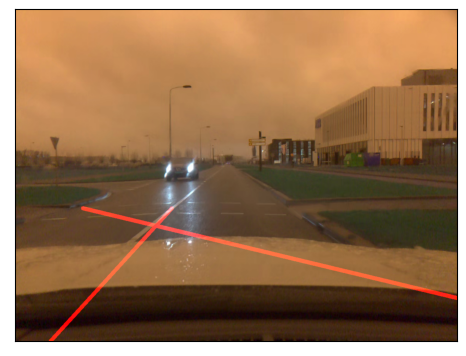

((-2, 874), (444, 524)) ((1248, 874), (202, 524))


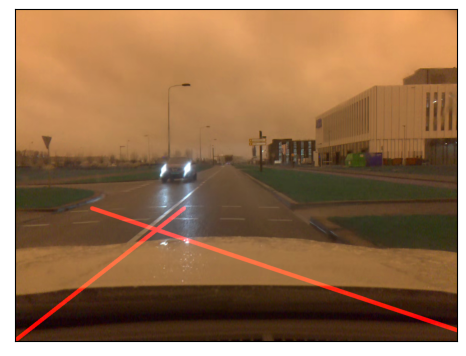

In [61]:

lm = LaneMemory()
for i in range(1200, 1220):
    current_img = np.copy(test_data[i])
    result = lm.process(current_img)
    show([result])